##  실습 : github ( 내 cars.csv 파일을 열고 sales 를 예측하세요 다음장에 데이터의 설명이 존재합니다 )

### 라이브러리 정의

In [1]:
# 데이터 처리 라이브러리
import pandas as pd
import numpy as np
# 분석알고리즘 DecisionTree 구현 라이브러리
from sklearn.tree import DecisionTreeRegressor 
# 과거데이터를 8:2, 7:3 이나 이런식으로 자동으로 나누어주는 라이브러리
from sklearn.model_selection import train_test_split

# 분석 알고리즘 DecisionTree 구현 라이브러리
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
# 딥러닝에서 많이씀!
from sklearn.preprocessing import LabelEncoder

# 정확도를 위한 지표들(분석(Regression)의 대표 평가지표 MAE, RMSE)
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

### 데이터 불러오기

In [20]:
featuresData = \
    pd.read_csv("https://raw.githubusercontent.com/hyokwan/python-lecture/master/dataset/cars.csv")
featuresData

,age,gender,miles,debt,income,sales
0,28,0,23,0,4099,620
1,26,0,27,0,2677,1792
2,30,1,58,41576,6215,27754
3,26,1,25,43172,7626,28256
4,20,1,17,6979,8071,4438
...,...,...,...,...,...,...
958,22,0,11,8778,9829,1593
959,19,1,23,4850,3470,4742
960,28,1,28,9312,2720,12771
961,50,0,29,51343,8713,28511


## 1. 데이터 전처리

### 1-1. 타입 통합 / 특성 숫자컬럼 추가

### 1-1-1. 데이터 타입 통합

In [9]:
featuresData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 963 entries, 0 to 962
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     963 non-null    int64  
 1   gender  963 non-null    int64  
 2   miles   963 non-null    int64  
 3   debt    963 non-null    int64  
 4   income  963 non-null    int64  
 5   sales   963 non-null    float64
dtypes: float64(1), int64(5)
memory usage: 45.3 KB


In [10]:
# 주의할 사항은 모든 컬럼에 대해서 고정시키는걸 고려햐는게 나을수도 있다
featuresData.sales = featuresData.sales.astype(float)

### 1-1-2. 특성 값 숫자컬럼 변경

In [12]:
##  어떤 컬럼들이 있는지 확인
featuresData.columns
# 변경할 것이 없으므로 넘어감 (예 Y -> 1로 변경 등)

Index(['age', 'gender', 'miles', 'debt', 'income', 'sales'], dtype='object')

### 1-2. 특성 선정 / 데이터 분리

### 1-2-1. 특성 선정

In [13]:
# 상관계수
featuresData.corr()

,age,gender,miles,debt,income,sales
age,1.000000,-0.000702,0.232399,0.218896,0.239644,0.352609
gender,-0.000702,1.000000,-0.031355,-0.033181,-0.034317,-0.036350
miles,0.232399,-0.031355,1.000000,0.544791,0.422141,0.636676
debt,0.218896,-0.033181,0.544791,1.000000,0.491790,0.835541
income,0.239644,-0.034317,0.422141,0.491790,1.000000,0.674685
sales,0.352609,-0.036350,0.636676,0.835541,0.674685,1.000000


In [14]:
corrDf = featuresData.corr()

In [15]:
standardLimit = 0.5

In [16]:
# 해당 조건에 맞는 컬럼들(index)을 변수로 저장
features = \
    list(corrDf.loc[ ( abs(corrDf.sales) > standardLimit ) & 
                    (corrDf.sales != 1) ].index )

In [17]:
features

['miles', 'debt', 'income']

In [18]:
# 정답지는 바뀌지 않으므로 하드코딩 해도됨
# 사실 하드코딩은 무조건 안됨. DB랑 연동해야함!
label = ["sales"]

### 1-2-2. 데이터 분리

In [21]:
standardIndex = 0.8

In [22]:
sortKey = ["age","gender","income"]

In [23]:
## 컬럼별로 정렬하기
sortedData = featuresData.sort_values(sortKey, ignore_index=True)

In [25]:
sortedData.shape

(963, 6)

In [27]:
# 정렬하고 80%에 있는 인덱스의 번호로 분리시킨다!
## 정렬을 하고 난 뒤에 80% 안에 들어오는 인덱스의 번호로 분리시키기 위해서
selectedIndex = int( list( sortedData.shape )[0] * standardIndex )

In [28]:
selectedIndex

770

In [32]:
## 분리를 위한 income 월수입
incomeStd = sortedData.loc[selectedIndex].income

In [33]:
incomeStd

5005

In [56]:
# 훈련데이터와 테스트데이터를 ( 문제지와 정답지를 구분해서 정의한다.)
trainingDataFeatures = \
    sortedData.loc[sortedData.income <= incomeStd, features] ## 조건, 컬럼명 을 넣어주는 것
trainingDataLabel = \
    sortedData.loc[sortedData.income <= incomeStd, label] ## 조건, 컬럼명 을 넣어주는 것
testDataFeatures = \
    sortedData.loc[sortedData.income > incomeStd, features] ## 조건, 컬럼명 을 넣어주는 것
testDataLabel = \
    sortedData.loc[sortedData.income > incomeStd, label] ## 조건, 컬럼명 을 넣어주는 것

In [57]:
# 기계에다가 학습시킬 훈련 데이터는 이게 된다!
trainingDataFeatures

,miles,debt,income
0,21,8814,0
1,15,5079,0
2,18,5425,0
3,10,5387,1735
4,16,1592,2962
...,...,...,...
942,21,9902,3219
951,12,0,1593
952,30,0,1843
953,28,882,3272


### 2. 모델적용

### 2-1. 모델 적용

### 2-1-1 학습

In [58]:
# 하이퍼 파라미터 튜닝 (분석가가 가장 많이 하는 일 중 하나)
# 모델 선언 (Decision, Random)
model_dt = DecisionTreeRegressor(random_state=10, max_depth=1)
model_rf = RandomForestRegressor(random_state=10)
model_lr = LinearRegression()

In [60]:
# X는 문제지, y는 정답지
# 학습은 이 2줄로 끝난다!
model_dt.fit(X=trainingDataFeatures, y=trainingDataLabel)
model_rf.fit(X=trainingDataFeatures, y=trainingDataLabel)
model_lr.fit(X=trainingDataFeatures, y=trainingDataLabel)

<ipython-input-60-2efe8d804c0e>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(X=trainingDataFeatures, y=trainingDataLabel)


LinearRegression()

### 3. 예측

In [61]:
# graphviz로 다 뜯어볼 수 있다
# explainable ai
predictValueDt = model_dt.predict(testDataFeatures)
predictValueRf = model_rf.predict(testDataFeatures)
predictValueLr = model_lr.predict(testDataFeatures)

In [62]:
testDataAll = \
    featuresData.loc[ testDataFeatures.index ] 

In [63]:
testDataAll

,age,gender,miles,debt,income,sales
6,44,1,17,418,7017,8520
7,39,1,28,0,3282,500
14,19,0,22,9362,4218,4531
15,53,1,47,3596,11069,18005
16,57,0,34,58481,7054,22854
...,...,...,...,...,...,...
958,22,0,11,8778,9829,1593
959,19,1,23,4850,3470,4742
960,28,1,28,9312,2720,12771
961,50,0,29,51343,8713,28511


In [64]:
testDataAll["PREDICT_DT"] = predictValueDt
testDataAll["PREDICT_RF"] = predictValueRf
testDataAll["PREDICT_LR"] = predictValueLr

In [65]:
predictDtMae = mean_absolute_error(y_true=testDataAll.sales,
                    y_pred=testDataAll.PREDICT_DT )
predictRfMae = mean_absolute_error(y_true=testDataAll.sales,
                    y_pred=testDataAll.PREDICT_RF )
predictLrMae = mean_absolute_error(y_true=testDataAll.sales,
                    y_pred=testDataAll.PREDICT_LR )

In [66]:
errorReportDf = pd.DataFrame( [[ predictDtMae, predictRfMae,predictLrMae     ]],
            columns=["DT_MAE","RF_MAE","LR_MAE"])

In [67]:
errorReportDf

,DT_MAE,RF_MAE,LR_MAE
0,9285.259557,8447.439119,10937.264545


In [68]:
features

['miles', 'debt', 'income']

### 4. 데이터 정리

In [72]:
testDataLabel.head()

,sales
6,2819
7,3418
14,3328
15,3351
16,4827


In [76]:
predictDtDf = \
    pd.DataFrame(list(predictValueDt) , columns=["PREDICT_DT"])
predictRfDf = \
    pd.DataFrame(list(predictValueRf) , columns=["PREDICT_RF"])
predictLrDf = \
    pd.DataFrame(list(predictValueLr) , columns=["PREDICT_Lr"])

In [77]:
validateDf = \
    pd.concat( [testDataLabel.reset_index(drop=True), predictDtDf, predictRfDf, predictLrDf], axis=1)

In [78]:
validateDf

,sales,PREDICT_DT,PREDICT_RF,PREDICT_Lr
0,2819,3937.595376,3957.01,6238.706007
1,3418,3937.595376,9028.15,10451.466375
2,3328,3937.595376,5946.28,7035.618839
3,3351,3937.595376,5202.79,7741.679270
4,4827,3937.595376,4554.50,9127.216154
...,...,...,...,...
608,15056,3937.595376,6856.10,8130.666858
609,8843,3937.595376,6696.53,8210.345641
610,25239,18733.250000,15791.77,26939.964759
611,27854,18733.250000,15791.77,28656.624259


# 5. 정확도 검증

In [84]:
maeDt = mean_absolute_error(y_true=validateDf.sales,
                    y_pred=validateDf.PREDICT_DT)
maeRf = mean_absolute_error(y_true=validateDf.sales,
                    y_pred=validateDf.PREDICT_RF)
maeLr = mean_absolute_error(y_true=validateDf.sales,
                    y_pred=validateDf.PREDICT_Lr)

In [85]:
rmseDt = np.sqrt( mean_squared_error(y_true=validateDf.sales,
                    y_pred=validateDf.PREDICT_DT) )
rmseRf = np.sqrt( mean_squared_error(y_true=validateDf.sales,
                    y_pred=validateDf.PREDICT_RF) )
rmseLr = np.sqrt( mean_squared_error(y_true=validateDf.sales,
                    y_pred=validateDf.PREDICT_Lr) )

In [89]:
maeDt, rmseDt

(6313.672413224076, 7695.573312857335)

In [90]:
maeRf, rmseRf

(5839.140848287113, 7080.977800178579)

In [91]:
maeLr, rmseLr

(4117.835955725498, 5150.797806322549)

In [92]:
features

['miles', 'debt', 'income']

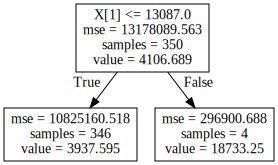

In [101]:
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(decision_tree=model_dt,
                out_file="tree.dot",
                impurity=True)
with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

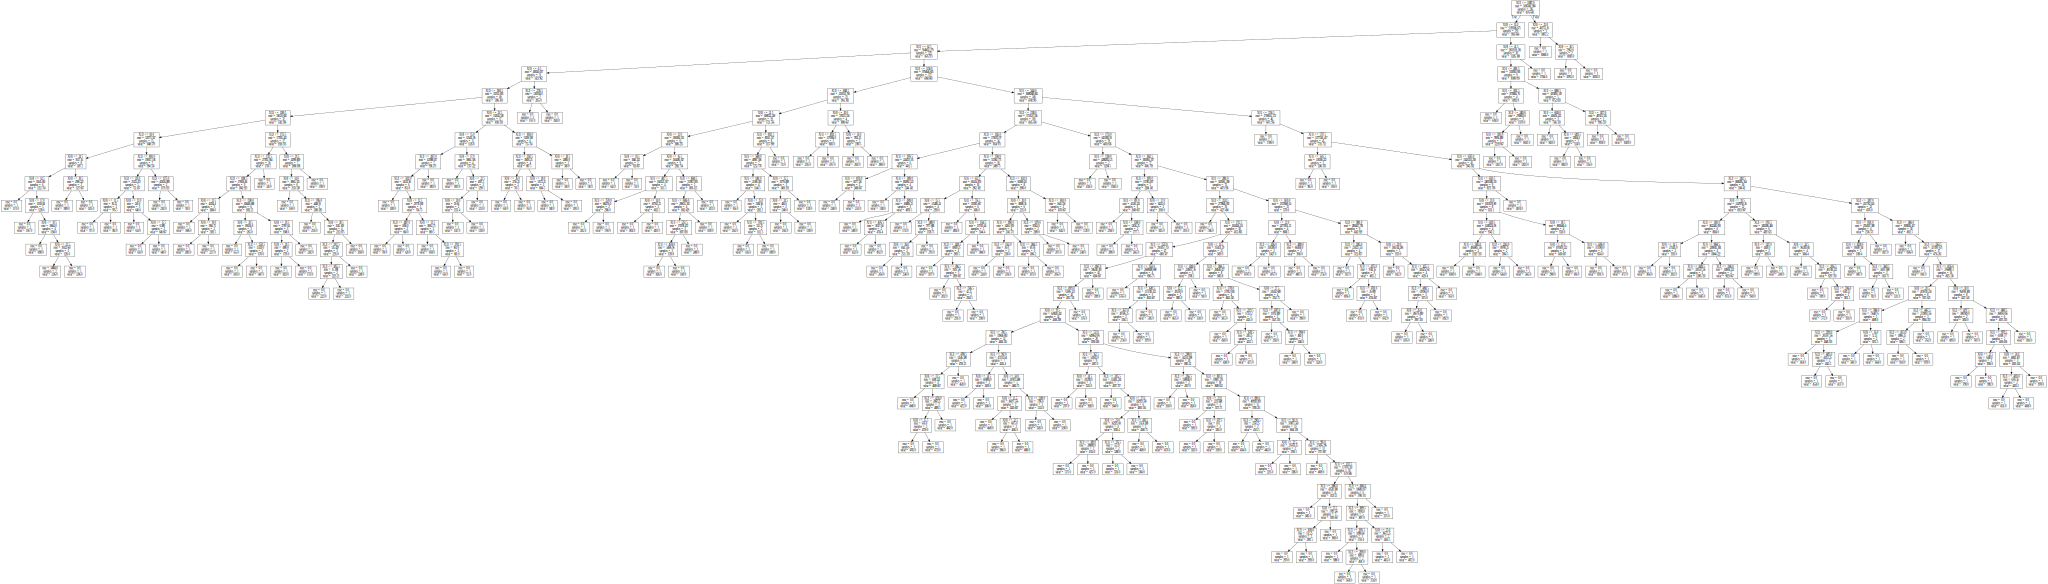

In [99]:
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(decision_tree=model_rf.estimators_[30],
                out_file="tree.dot",
                impurity=True)
with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))